# LEARNING ACTIVITY: Regularization 

---

Learning goals:  implement and explore the results of using Data Augmentation and Early stopping.  To do this you will also need to set up higher capacity models.

There are 3 areas of code required:

* STEP 1. Build an early stopping mechanism within the ```fit``` function of the ```ANN``` Class
* STEP 2. Implement data augmentation in the ```generateAugmentedTrainData``` function
* STEP 3. Implement a higher capacity model to use these techniques on - in the portion of the code that builds and evaluates models

These student code components will be used to demonstrate performance of small and bigger networks with and without Data Augmentation.  Early stopping will be used in all of these to prevent overfitting.  The sequence of evaluations is:

* Train a small network without data augmentation.  (doesnt work well)
* Train the same small network *with* data augmentation to see if it improves  (doesnt work well)
* Train a larger network without data augmentation (doesnt work well)
* Train the same larger network *with* data augmentation to see if it improves (works!)



In [2]:
import os
import numpy as np
import copy
import matplotlib.pyplot as plt

EPS = np.finfo(np.float32).eps  #minimum floating point number for numerical stability in calculations

---

# Setup

---

### Helper functions for visualizing data, newtwork outputs, and train/val loss curves per ecoch

In [3]:
def dataplotter(featureData, labelData, title, show=True):
    '''plot annotated points to show where the boolean inputs lie on the graph''' 

    fig, ax = plt.subplots()

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

        
#     ax.scatter(featureData[:, 0], featureData[:, 1], color='b', alpha=0.2)
    for i, txt in enumerate(labelData):
        ax.annotate(txt.item(), (featureData[i, 0], featureData[i, 1]))

        # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title(title)
    if show:
        plt.show()
    




def makeDecisionBoundaryBool2(model, featureData, labelData, title, show = True):
    '''Build decision boundary figrue for 2-input, 1-output boolean logic functions
    Note that this assumes a hard sigmoid was used and establishes a cutoff at 0.5
    for predicting 0 or 1'''
    cutoff = 0.5  # 0.5 for Sigmoid. 0.0 for TANH
    fig, ax = plt.subplots()

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

    # Create filled countour map to color both sides of the boundary
    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    preds = model.predict(grid)  # get predictions
    z = preds.reshape(X.shape) > cutoff  # cutoff on predictions to return boolean output
    plt.contourf(X, Y, z, cmap='YlOrBr')

    # add annotated points to show where the boolean inputs lie on the graph
    ax.scatter(featureData[:, 0], featureData[:, 1], color='b', alpha=0.5)
    for i, txt in enumerate(labelData):
        ax.annotate(txt.item(), (featureData[i, 0], featureData[i, 1]))

        # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title(title)
    if show:
        plt.show()


def show2dFunctionOutput(model_function, featureData, labelData, title, show=True):
    """display results of arbitrary model function on 2-input (x1,x2) , 1-output (z) graphs"""
    # cutoff = 0.5  # 0.5 for Sigmoid. 0.0 for TANH
    fig, ax = plt.subplots(figsize=(8,5))

    xmin, xmax = np.min(featureData[:, 0]) - 0.1, np.max(featureData[:, 0]) + 0.1
    ymin, ymax = np.min(featureData[:, 1]) - 0.1, np.max(featureData[:, 1]) + 0.1

    # Create filled countour map to color both sides of the boundary
    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(), Y.ravel()]
    outputs, _, _, _ = model_function(grid)  # get predictions
    z = outputs.reshape(X.shape)  # reshape predictions for 2d representation
    plotlevels = np.linspace(0.,1., 25)  # split colors between 0 and 1
    CS = plt.contourf(X, Y, z, levels = plotlevels, cmap='YlOrBr')

    # add annotated points to show where the boolean inputs lie on the graph
    ax.scatter(featureData[:, 0], featureData[:, 1], color='b', alpha=0.5)
    for i, txt in enumerate(labelData):
        ax.annotate(txt.item(), (featureData[i, 0], featureData[i, 1]))

    
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('raw network output')
    # adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')

    plt.title(title)
    if show:
        plt.show()
    
def showLossHistory(tng_loss_history=[],val_loss_history=[],semilog=True,plotname="", show=True):
    plt.figure()
    if semilog:
        plt.semilogy(tng_loss_history,'r', label = "Training Loss")
        plt.semilogy(val_loss_history, 'b', label = "Validation Loss", alpha = 0.5)
        plt.ylabel("Loss (BCE) - semilog scale")

    else:    
        plt.plot(tng_loss_history,'r', label = "Training Loss")
        plt.plot(val_loss_history, 'b', label = "Validation Loss", alpha = 0.5)
        plt.ylabel("Loss (BCE)")
    plt.xlabel("epoch")
    plt.legend()
    plt.title(plotname+" Loss over epochs")
    if show:
        plt.show()
    

### Defining the activation functions and their derivatives

In [4]:
def sigmoid(x):
    #handle if the x is a big negative number to prevent exp overflow
    safe_x = ((-x>700.)*(-700.)) + (-x<=700.)*x  #cap the max negative value to be -700 which would essentially make sigmoid(x) return 0
    return 1. / (1. + np.exp(-safe_x))


def dSigmoid(x):  # derivative of sigmoid
    s = sigmoid(x)
    return np.multiply(s, (1-s))


def relu(z):  # rectified linear unit activation
    return np.maximum(0, z)


def dRelu(z):
    """ 
    Derivative of Rectified Linear Unit

    """
    return 1 * (z > 0)


---

The code below implements an ANN class with forward prop and backporpagation components from Goodfellow's deep learing book, algorithms 6.3 and 6.4

In [5]:
def L2_reg_gradient(inputs):
    return inputs

def L1_reg_gradient(inputs):
    return np.sign(inputs)

def No_regularization(inputs):
    return 0*inputs

class ANN:
    data = []
    layers = []
    inputWidth = 1
    outputWidth = 1
    regularizer_gradient_fcn = [] 

    class Layer:

        """class defining the elements of an ANN layer"""

        def __init__(self):
            self.w = []
            self.b = []
            self.nodecount = []
            self.activation_fcn = []
            self.activation_fcn_derivative = []
            self.regularizer_gradient_fcn = [] 
            self.layer_reg_lambda = 0
            self.orderNumber = []
            self.previous = None  # link to previous layer
            self.next = None  # link to next layer

        def set_weights(self, w, b):
            """set the weights and bias for the layer.  Layer weights should have dimesion: (thislayer_nodecount, previouslayer_nodecount)
            the dimension of the bias should be (thislayer_nodecount,1)"""
            self.w = w
            self.b = b
            return self

        
        def initialize_weights(self, seed=None):
            assert self.w.size > 0
            assert self.b.size > 0
            np.random.seed(seed)  
            self.w = np.random.normal(size=(self.w.shape))  # hidden weight matrix [rows = to, columns = from]
            self.b = np.random.normal(size=(self.b.shape))  # hidden biases (column vector)

        def get_layer(self):
            """get the current state for the layer.  """
            return self

        def set_activation(self, activation_fcn):
            self.activation_fcn = activation_fcn
            return self

        def set_activation_deriv(self, activation_fcn):
            if activation_fcn == sigmoid:
                self.activation_fcn_derivative = copy.deepcopy(dSigmoid)
            elif activation_fcn == relu:
                self.activation_fcn_derivative = copy.deepcopy(dRelu)
            else:
                self.activation_fcn_derivative = None
                
        def display_params(self):
            """displays the weights and biases of the layer (rows = to, colums = from)"""
            for outNum in range(self.w.shape[0]):
                print(self.w[outNum,:], "  ", self.b[outNum])
        

        def compute_pre_activation(self, inputs):
            net = np.dot(self.w, inputs) + self.b
            return net

        def compute_bias_gradient(self, gradient):
            g = np.mean(gradient, axis=1)[:, np.newaxis]  # no regularization
            return g

        def compute_weight_gradient(self, inputs, gradient):
            g_omega = self.regularizer_gradient_fcn(self.w)
            g = np.dot(gradient, inputs.T) + self.layer_reg_lambda * g_omega
            return g

        def compute_activation(self, net):
            return self.activation_fcn(net)

        def compute_activation_derivative(self, net):
            return self.activation_fcn_derivative(net)

        def compute_activation_gradient(self, net, gradient):
            g = np.multiply(gradient, net)
            return g

        def compute_forward(self, inputs):
            """Returns layer ouput from input (shape = [nodeCount, input]) of the weighted input plus bias
            input shape must be [lastlayer_nodeCount, samples] or [featurecount, samplecount] """
            net = self.compute_pre_activation(self, inputs)
            layer_out = self.compute_activation(net)
            return layer_out

        def compute_layer_gradients(self, inputs, net, activation, gradient):
            """ computes the loss gradient with respect to desired output of the layer
            a set of desired targets is assumed to be matrix of shape [nodecount, samples]: SGD will have [nodecount,1]
            hidden_inputs is assumed to be a matrix of shape [hiddenNodeCount, samples]
            
            This follows algorithm 6.4 line by line in the book!
            
            """
            
            # f'(a(k))
            d_activation = self.compute_activation_derivative(net)  # derivative of sigmoid:  shape = [NodeCount, samples]
            
            # g <- g * f'(a(k))
            g_loss = self.compute_activation_gradient(d_activation, gradient)  # shape = [NodeCount, samples]  for outer layer
            
            # Delta_b(k) J = g (Take the mean across all 4 samples (batch))
            g_loss_b = self.compute_bias_gradient(g_loss)  # mean gradient with respect to BIAS, shape = [NodeCount, 1]
            
            # Delta w(k) J = g * h(k-1)
            g_loss_w = self.compute_weight_gradient(activation, g_loss)  # [1, 3]  Hidden layer outputs after activation
            
            # g <- W(k).T * g
            g_loss_backprop = np.dot(self.w.T, g_loss)  # gradient to propagate back, shape = [hiddenNodeCount,samples]
            
            return g_loss_w, g_loss_b, g_loss_backprop

        def update_Layer(self, weightUpdate, biasUpdate):
            self.w = self.w + weightUpdate
            self.b = self.b + biasUpdate

    def __init__(self):
        self.data = []
        self.layers = []
        self.inputWidth = 1
        self.outputWidth = 1

    def set_input_width(self, inputWidth):
        """defines the input layer width for the network"""
        self.inputWidth = inputWidth

    def add_layer(self, nodecount=1, activation_fcn=relu, regularizer_gradient_fcn=L2_reg_gradient, reg_lambda = 0.1):
        """adds a layer to the neural network and returns the layer"""
        oldLayerCount = len(self.layers)
        thislayer = ANN.Layer()
        thislayer.orderNumber = oldLayerCount + 1

        if oldLayerCount > 0:  # other layers have been added already
            lastLayer = self.layers[-1]
            lastLayer.display_params()
            thislayer.previous = lastLayer
            lastLayer.next = thislayer
            layerInputSize = lastLayer.w.shape[0]
        else:  # this will be the first layer
            layerInputSize = self.inputWidth
            
        thislayer.w = np.zeros((nodecount, layerInputSize))  #[NODECOUNT,FROM]
        thislayer.b = np.zeros((nodecount, 1 )) #[NODECOUNT,FROM]
        thislayer.activation_fcn = activation_fcn
        thislayer.set_activation_deriv(activation_fcn)
        thislayer.regularizer_gradient_fcn=regularizer_gradient_fcn
        thislayer.layer_reg_lambda = reg_lambda
        self.outputWidth = nodecount
        self.layers = self.layers + [thislayer]
        return thislayer
    
    def initialize(self, seed = None):
        """initialize weights & biases: overwrites current network parameters"""
        for layer in self.layers:
            layer.initialize_weights(seed)
    
    def summary(self):
        """displays a summary of the model"""
        tot_train_parameters = 0
        print("\n")
        print("Layer     Inshape     Outshape     Param #  ")
        print("================================")
        for lnum, layer in enumerate(self.layers):
            inshape = layer.w.shape[1]
            weightCount = layer.w.shape[0]*layer.w.shape[1]  #assume fully connected
            biasCount = layer.b.shape[0]
            thislayerparams = weightCount+biasCount
            tot_train_parameters += thislayerparams
            print("% 3d      % 3d          % 3d        %3d " %(lnum,inshape,biasCount,thislayerparams))
        print("================================")
        print("total trainable params: ",tot_train_parameters )
        
    def display_params(self):
        """displays the weights and biases of the network (rows = to, colums = from)"""
        print("\n")
        print("input width: ", self.inputWidth)
        for lnum, layer in enumerate(self.layers):
            print("Layer ",lnum)
            layer.display_params()
        print("output width: ", layer.w.shape[0])
        
    def get_state(self):
        return self
                
                
    def forwardPropagation(self, inputs):
        """Compute forward pass of two layer network
        inputs are assumed to be (shape=[sampleCount,featureCount])
        returns a matrix of raw outputs with one row of output per node (shape=[sampleCount, outputNodeCount])
        Internal matrices are shaped for efficiency to avoid internal transposes (columns hold observations/samples) """

        # inputs and outputs will be transposed for efficiency during forwardPropagation and untransposed before returning

        nets = []
        activations = []
        layer_input = inputs.T

        for lnum, layer in enumerate(self.layers):
            # inputs = inputs + inputs
            layer_net = layer.compute_pre_activation(layer_input)
            nets.append(layer_net)

            layer_out = layer.compute_activation(layer_net)
            activations.append(layer_out)

            layer_input = layer_out
        raw_output = layer_out.T
        return raw_output, inputs, nets, activations

    def backPropagation(self, inputs, desiredOutputs, learningRate):
        w_grads = []
        b_grads = []
        # store nets and activations for each layer
        raw_output, _, nets, activations = self.forwardPropagation(inputs)
        layer_desired_out = desiredOutputs

        # Note: This is only part of the gradient
        layer_grad = desiredOutputs - raw_output

        #  computation of full gradient handled inside the loop below
        for lnum, layer in reversed(list(enumerate(self.layers))):
            if lnum == 0:  #INPUT LAYER
                prev_layer_output = inputs.T
            else: # NOT INPUT LAYER
                prev_layer_output = activations[lnum - 1]
                
            if lnum == len(self.layers)-1:  #OUTPUT LAYER
                w_grad, b_grad, loss_grad = layer.compute_layer_gradients(prev_layer_output, nets[lnum], prev_layer_output,
                                                                          layer_grad.T)
            else:  #NOT OUTPUT LAYER
                w_grad, b_grad, loss_grad = layer.compute_layer_gradients(prev_layer_output, nets[lnum], prev_layer_output,
                                                                          layer_grad)
            layer.update_Layer(w_grad * learningRate, b_grad * learningRate)
            layer_grad = loss_grad

    def predict(self, X, threshold=0.5):
        """Compute predictions using forward propagation for single binary classification at threshold
        X is a standard dataFrame without biases (shape=[observationCount,featureCount])
        returns a standard column vector of binary predictions in {0,1}: (shape=[observationCount, 1])"""
        raw_predictions, net_inputs, net_lst, activation_lst = self.forwardPropagation(X)
        preds = raw_predictions > threshold
        return preds

    def compute_loss(self, raw_outputs, desired_targets):
        """
        computes the (scalar) loss using Binary Cross Entropy of a set raw ouputs and desired targets 
        raw_outputs and desired_targets are assumed to be arrays of shape [samples, 1]
        """
        y = desired_targets
        bce = -np.mean( (y*np.log(raw_outputs+EPS)) + ((1-y)*np.log(1-raw_outputs+EPS)) )
        #using EPS to prevent log(0) numerical problems
        return bce
    

## STEP 1: Student Coding:

Add early stopping based on validation loss & valpatience in the ```fit``` function definition near the bottom of this cell

In [6]:
#this extends the class ANN to make it easy to find the code where the student needs to work
class ANN(ANN):
    
    def fit(self, tngInputs, tngTargets, valInputs, valTargets, learningRate, learningRateDecay,
            valPatience=0, val_tolerance=1e-3, maxEpochs = 100):
        """fit model to map tngInputs to tngTargets. If valPatience > 0 then use early stopping on valInputs & valTargets
        returns training loss history and val loss history """
        done = False
        tng_loss_history = []
        val_loss_history = []
        print("Training Model...")
        epoch = 0
        
        # get current training performance before starting training
        raw_Train_output, _, _, _ = self.forwardPropagation(tngInputs)
        tngPreds = self.predict(tngInputs)
        tngCorrect = tngTargets == tngPreds
        curr_train_loss = self.compute_loss(raw_Train_output, tngTargets).item()
        tng_loss_history.append(curr_train_loss)

                
        #get current val performance before starting training
        raw_Val_output, _, _, _ = self.forwardPropagation(valInputs)
        valPreds = self.predict(valInputs)
        prev_val_loss = self.compute_loss(raw_Val_output, valTargets).item()
        val_loss_history.append(prev_val_loss)
        
        
        #initialize val counter for early stopping
        val_epochs_nonimproved = 0
        best_epoch = 1
        best_net = copy.deepcopy(self.get_state())  #keep track of the best performing net so far
        
        while not done:
            epoch+=1
            if epoch>maxEpochs: 
                done = True
            
            #run one epoch of backprop
            self.backPropagation(tngInputs, tngTargets, learningRate=learningRate)
            
            # compute and save training loss history for this epoch
            raw_Train_predictions, _, _, _ = self.forwardPropagation(tngInputs)
            tngPreds = self.predict(tngInputs)
            tngCorrect = tngTargets == tngPreds
            curr_train_loss = self.compute_loss(raw_Train_predictions, tngTargets).item()
            tng_loss_history.append(curr_train_loss)
            
            #compute and save validation loss history for this epoch
            raw_Val_output, _, _, _ = self.forwardPropagation(valInputs)
            valPreds = self.predict(valInputs)
            cur_val_loss = self.compute_loss(raw_Val_output, valTargets).item()
            val_loss_history.append(cur_val_loss)
            learningRate = learningRate * learningRateDecay
            

            # WRITE CODE BELOW TO IMPLEMENT EARLY STOPPING USING VAL LOSS IMPROVEMENT
            # if validation loss has not improved in patience epochs then stop
            # you will need to consider the parameters passed into this function:
            #
            # valPatience (default=0): how many epochs to wait before halting training due to lack of improvement; if zero, dont use ear.y stopping
            # val_tolerance= (default = 1e-3):  how much better the new network has to perform than the previous best network
            #
            # you should set / use these variables as part of this activity:
            # prev_val_loss:  the last best validation loss
            # val_epochs_nonimproved:  a running count of the number of epochs since last improvement
            # best_epoch:  the epoch of current best performance
            # best_net:  the settings of the best network  [use "copy.deepcopy(self.get_state())"] to caputure this

            #######################################################################################################
            ###################################### STUDENT CODE ###################################################
            
            if cur_val_loss < (prev_val_loss-val_tolerance):  #check to see if at least some minimum improvement is made
                
                #if achieved, reset the nonimproved counter
                val_epochs_nonimproved = 0

                #capture the current val loss as the best so far
                prev_val_loss = cur_val_loss
                
                #save model params if best so far...                
                #record the best epoch number
                best_epoch = epoch
                
                #capture the network state using "best_net = copy.deepcopy(self.get_state())"
                best_net = copy.deepcopy(self.get_state())
                
            else:  #adequate improvement wasnt made
                
                #increment the number of val epochs not improved
                val_epochs_nonimproved += 1
                
                #test to see if val patience has been exceeded, and if so...
                if val_epochs_nonimproved > valPatience:

                    #print a statement telling user that early stopping is happening after patience exceeded and report the current epoch
                    print('Early stopping has occured. %i epochs executed without improvement.' % valPatience)
                
                    #report that the model will restore the previous best state
                    print('Best state occured in epoch %i' % best_epoch)
                    print('Restoring model to best state...')
                    
                    #restore the best state using "self = best_net"
                    self = best_net
                    
                    # set "done=True" to cease network training
                    done = True
                
                
                    
            #################################### END STUDENT CODE #################################################
            #######################################################################################################


            
        print("Training Complete!")

        return tng_loss_history, val_loss_history

### Helper function to instantiate an ANN from parameters

In [7]:
def make_ANN_model(input_width = 2,
                   layer_widths = [3,1],
                   layer_activiations = [sigmoid,sigmoid],
                   regularizer_gradient_fcn=L2_reg_gradient,
                   reg_lambda = 0.01,
                   seed = None):
    model = ANN()
    print()
    print(list(zip(layer_widths,layer_activiations)))
    model.set_input_width(input_width)
    print("\n Generating Model Architecture:")
    for lnum,(layerWidth,layerActivation) in enumerate(zip(layer_widths,layer_activiations)):
        print("Adding layer: ",lnum, " with nodecount = ", layerWidth, ", activation_fcn =", layerActivation)
        model.add_layer(nodecount = layerWidth, activation_fcn=layerActivation, regularizer_gradient_fcn=regularizer_gradient_fcn , reg_lambda = reg_lambda)
    model.initialize(seed)
    return model
        
 
    
    

### Helper function to train an ANN from parameters.  Allows for separate training and validation data

In [8]:
def train_ANN_model(model=None,
                    trainX = None, trainY = None,
                    valX=None,valY=None,
                    learning_rate=1.0,
                    lr_decay=0.999,
                    valPatience=0,
                    maxEpochs = 100,
                    plotname=""):
    
    

    preds = model.predict(valX)
    correct = valY == preds
    print("\n BEFORE TRAINING (randomized weights)")
    model.display_params()
    print("\n")
    print("predictions: \n", preds)
    print("Predictions correct?: \n", correct)

    #fit(self, tngInputs, tngTargets, valInputs, valTargets, learningRate, learningRateDecay,
    #        valPatience=0, tolerance=1e-2, maxEpochs = 100)
    tng_loss_history,val_loss_history = model.fit(tngInputs=trainX, tngTargets=trainY, valInputs=valX, valTargets = valY,
                                                  learningRate=learning_rate, learningRateDecay=lr_decay, valPatience=valPatience,
                                                  val_tolerance=0.01, maxEpochs=maxEpochs)

    preds = model.predict(valX)
    correct = valY == preds

    print("\n \n AFTER TRAINING (learned model weights) ")
    model.display_params()

    print("\n")
    print("predictions: \n", preds)
    print("Predictions correct?: \n", correct)

    show2dFunctionOutput(model.forwardPropagation, X, Y, plotname+ " Raw Response of Network")
    makeDecisionBoundaryBool2(model, X, Y, plotname+ " XOR threshold predictions")
    showLossHistory(tng_loss_history,val_loss_history,plotname)
    
    return tng_loss_history, val_loss_history


---

### Helper function to produce datasets for logic gates

In [9]:
def get_input_output_data(gate='XOR'):
    """ Two dimensional inputs for logic gates

    Parameters
    ----------
    gate : str
        Must be either AND, OR, XOR

    Returns
    -------
    X : array-like, shape(samples, features)
        Two dim input for logic gates

    truth[gate] : array-like, shapes(samples, )
        The truth value for this logic gate

    """

    X = np.array([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])

    truth = {
        'AND': np.array([0, 0, 0, 1]),
        'OR': np.array([0, 1, 1, 1]),
        'XOR': np.array([0, 1, 1, 0])
    }

    return X, truth[gate][:, np.newaxis]

---

# Training the networks

Here we implement both a small and large network and use both data augmentation and early stopping as regularization techniques to see how they perform on these networks.

Students will need to implement the architecture for the larger network and implement data augmentation below.

---

### Globals for repeatability of expriements

In [10]:
NETWORK_INIT_SEED = 1  # global value for starting seed initialization for network weights
DATA_AUGMENT_SEED = 1  # global value for starting seed initialization for data generation random number sequence
VAL_PATIENCE = 200     # number of epochs to wait for validation performance improvement
MAX_EPOCHS = 10000     # maximum number of epochs to train before quitting training
LEARNING_RATE = 0.01
LEARNING_RATE_DECAY = 1.0  # Float required.  Set to 1.0 for no decay.  set on the interval [0,1) for exponential decay
REGULARIZER_GRADIENT_FUNCTION = No_regularization  #function used for netw parameter regularization (not used in this demo; set to No_regularization)
REGULARIZER_LAMBDA = 0.0 #multiplier for regularization function (not used in this demo; set to zero)

---

## Example: Smallest-possible XOR Network 

In [11]:
small_model = make_ANN_model(input_width = 2,
                             layer_widths = [2,1],  #number of nodes in each layer
                             layer_activiations = [relu,sigmoid],  #activations at each layer
                             regularizer_gradient_fcn=REGULARIZER_GRADIENT_FUNCTION,
                             reg_lambda=REGULARIZER_LAMBDA, #no regularization
                             seed = NETWORK_INIT_SEED)  

print("empty model info")
small_model.summary()


[(2, <function relu at 0x7f83c0909c10>), (1, <function sigmoid at 0x7f83c0909af0>)]

 Generating Model Architecture:
Adding layer:  0  with nodecount =  2 , activation_fcn = <function relu at 0x7f83c0909c10>
Adding layer:  1  with nodecount =  1 , activation_fcn = <function sigmoid at 0x7f83c0909af0>
[0. 0.]    [0.]
[0. 0.]    [0.]
empty model info


Layer     Inshape     Outshape     Param #  
  0        2            2          6 
  1        2            1          3 
total trainable params:  9


### Train the small network without data augmentation

Note that we will use the same 4 XOR datapoints for both trianing and validation here.


 BEFORE TRAINING (randomized weights)


input width:  2
Layer  0
[ 1.62434536 -0.61175641]    [0.86540763]
[-0.52817175 -1.07296862]    [-2.3015387]
Layer  1
[ 1.62434536 -0.61175641]    [-0.52817175]
output width:  1


predictions: 
 [[ True]
 [False]
 [ True]
 [ True]]
Predictions correct?: 
 [[False]
 [False]
 [ True]
 [False]]
Training Model...
Early stopping has occured. 200 epochs executed without improvement.
Best state occured in epoch 486
Restoring model to best state...
Training Complete!

 
 AFTER TRAINING (learned model weights) 


input width:  2
Layer  0
[ 1.09709535 -0.4860757 ]    [0.74347842]
[-0.52817175 -1.07296862]    [-2.3015387]
Layer  1
[ 0.53140535 -0.61175641]    [-0.63681665]
output width:  1


predictions: 
 [[False]
 [False]
 [ True]
 [ True]]
Predictions correct?: 
 [[ True]
 [False]
 [ True]
 [False]]


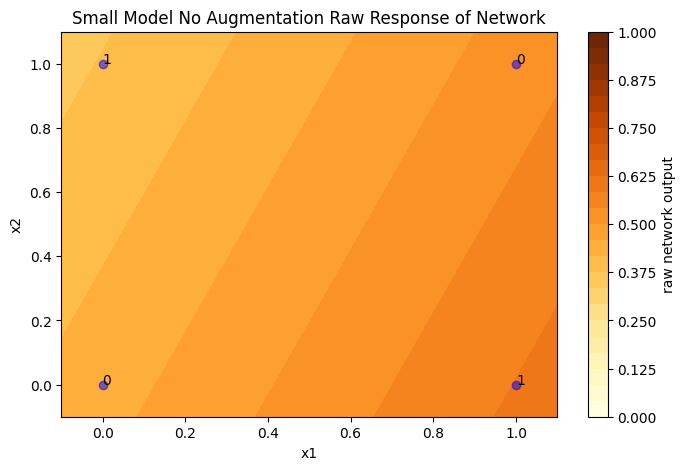

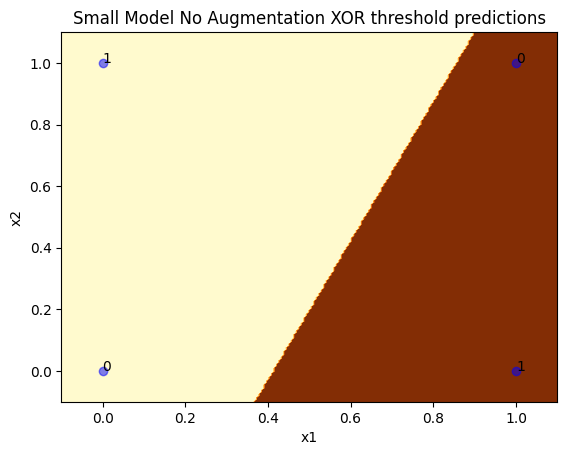

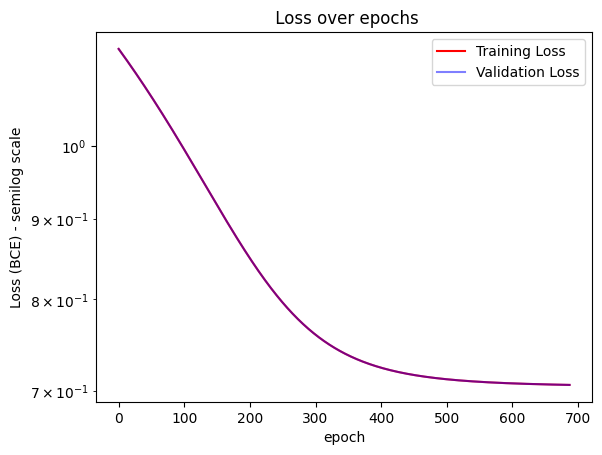

In [12]:
X, Y = get_input_output_data(gate='XOR')

trainX = X
trainY = Y
valX = X
valY = Y

_ = train_ANN_model(small_model,trainX,trainY,valX,valY,
                learning_rate=LEARNING_RATE,lr_decay=LEARNING_RATE_DECAY,
                valPatience = VAL_PATIENCE, maxEpochs = MAX_EPOCHS, plotname = "Small Model No Augmentation")


#note that the underscore above tells python to not capture the returned training history from the model trainer (otherwise it would print out to screen)

Results:  Here we can see that the network is unable to replicate the XOR function






---


## STEP 2: Student Code - Implement Data Augmentation

Create and return augmented training dataset by adding small amounts of random gaussian noise to randomly selected X datapoints, but keep the same Y labels for those points.

Note that you should NOT return the original data X... only the new augmented datapoints.

Tips:  
* Use ```np.random.randint``` to select a set of indices of the data for augmentation.  In this way you can generate many random samples (with replacement) for new x data.
* Choose either ```np.random.normal``` or  ```np.random.uniform``` to generate a (small) random noise value of the same shape as the observation (a vector)
    * Remember to keep the ```scale``` (standard deviation of normal distrution) or ```low``` and ```high``` parameters of the uniform distribution small so you dont fundamentally change the meaning of an XOR observation
* Add the noise vector to only the values of X (dont add it to Y labels)



In [18]:
def generateAugmentedTrainData(X,Y,augscale=0.0, augCount=100, seed = None):
    """starting with original datapoints X and labels Y, return new augmented datapoints of size augCount"""
    np.random.seed(seed=seed)
    xtrain = X #placeholder only
    ytrain = Y #placeholder only
    

    # make a larger dataset in which you add a small random perturbation to the features of each datapoint
    # note that you should NOT return the original data X and Y - only return the newly generated (augmented data) points
    # Challenge: You should be able to do this without a for loop since numpys random generators are all vectorized. Just make sure your array shapes are compatible.
    # Hint:  to generate a larger set of points from a smaller set of points ("X"), 
    #        you can draw (with repetition & with replacement) a set of N indeces of datapoints from X using "idx=np.random.randint(X.shape[0], size=N)"
    #        then, using "X[idx]"", you can refer to that new larger set of points
    # Hint:  if you generate a vector of noise elements (np.random.uniform) of the quantity (augCount), you can just add those vectors to an equivalent-sized randomly drawn sample from X
    
    xtrain = []  #placeholder - will be filled with quantity augCount observations of the original observation shape of X
    ytrain = []  #placeholder - will be filled with quantity augCount observations of the original label shape of Y
    
    ##### STUDENT CODE FOR DATA AUGMENTATION #############
    idx=np.random.randint(X.shape[0], size=augCount)
    xtrain = X[idx] + (np.random.random((augCount,X.shape[1]))-0.5)*augscale
    ytrain = Y[idx] 
    
    ############# END STUDENT CODE #######################
    
    return xtrain,ytrain

---

## Train the small network using data augmentation

### Reinitialize the small network

In [19]:
small_model.initialize(seed=NETWORK_INIT_SEED)
small_model.summary()



Layer     Inshape     Outshape     Param #  
  0        2            2          6 
  1        2            1          3 
total trainable params:  9


### Re-Train the small network using data augmentation

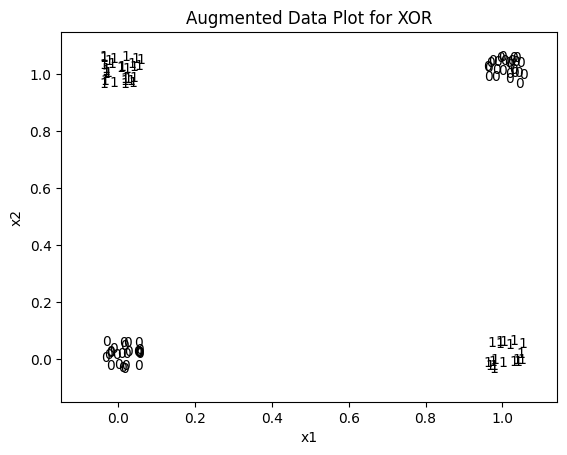


 BEFORE TRAINING (randomized weights)


input width:  2
Layer  0
[ 1.62434536 -0.61175641]    [0.86540763]
[-0.52817175 -1.07296862]    [-2.3015387]
Layer  1
[ 1.62434536 -0.61175641]    [-0.52817175]
output width:  1


predictions: 
 [[ True]
 [False]
 [ True]
 [ True]]
Predictions correct?: 
 [[False]
 [False]
 [ True]
 [False]]
Training Model...
Early stopping has occured. 200 epochs executed without improvement.
Best state occured in epoch 20
Restoring model to best state...
Training Complete!

 
 AFTER TRAINING (learned model weights) 


input width:  2
Layer  0
[0.7392156  0.09659658]    [0.86450248]
[-0.52817175 -1.07296862]    [-2.3015387]
Layer  1
[ 0.27312794 -0.61175641]    [-0.51690967]
output width:  1


predictions: 
 [[False]
 [False]
 [False]
 [False]]
Predictions correct?: 
 [[ True]
 [False]
 [False]
 [ True]]


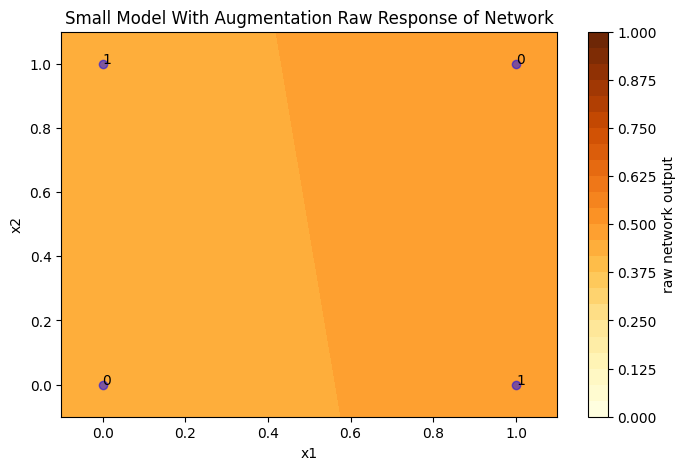

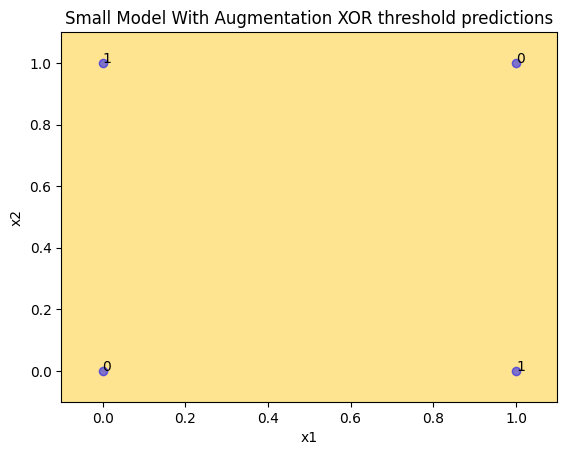

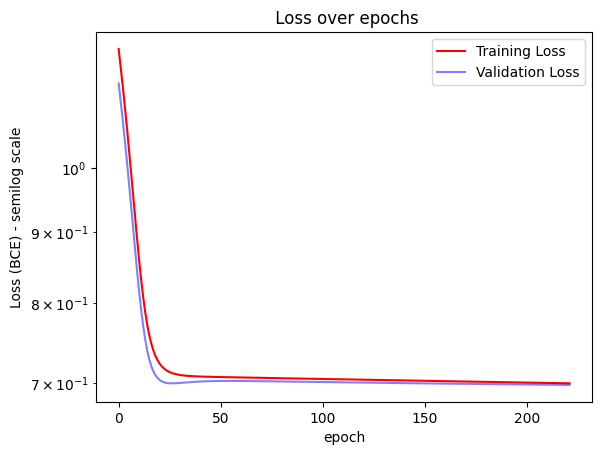

In [20]:
X, Y = get_input_output_data(gate='XOR')

x_augmented,y_augmented = generateAugmentedTrainData(X,Y,augscale=0.1,augCount=100, seed = DATA_AUGMENT_SEED)  #save these augmented for later

#use only the augmented data for training
trainX = x_augmented
trainY = y_augmented

dataplotter(trainX,trainY,"Augmented Data Plot for XOR")

#use only the real original labeled data for validation
valX = X
valY = Y

#note that the underscore below says dont capture the returned training history from the model trainer (otherwise it would print out to screen)

_ = train_ANN_model(small_model,trainX,trainY,valX,valY,
                learning_rate=LEARNING_RATE,lr_decay=LEARNING_RATE_DECAY,
                valPatience = VAL_PATIENCE, maxEpochs = MAX_EPOCHS, plotname = "Small Model With Augmentation")


Results:  We can see that the smaller network with data augmentation also fails to find a decision boundary

(note:  training loss may be worse than val loss becasue of the training points being spread over a larger portion of the domain)

---

# STEP 3: student coding - Make a higher-capacity network

Increase the capacity of the network.  This should make it easier for the network to learn... as long as it is not too big and struggles with gradient explosion or dissappearing

Use more layers and/or more nodes per layer.  Here you are ONLY defining the hidden layers (not the output; the ouput layer will be appended by the instructor code)

e.g., ```hidden_layer_widthshidden_layer_widths = [2,2]``` 

and make sure the last layer has a sigmoid output 

e.g., ```hidden_layer_activationshidden_layer_activations = [sigmoid,sigmoid]```

In [15]:
# enter the code below to set up the layers and activations for your network
# each of these should be a list, with the first member of the list being the input size and the last member of the list describing the output layer
# remember that the output width should be 1 and the output activation should be sigmoid

# my_layer_widths = [L1width,L2width...,LNwidth]
# my_activations = [L1a,L2a,...LNa]

# where L1width, L2width ... LNwidths are integer shapes of the network from first hidden layer to output layer (layer).  Last layer should be a 1
# where L1a, L2ah ... LNa are the activation functions of the network from first hidden layer to output layer (layer).  Last layer should be a sigmoid if doing classification or logic gates


# example of small 2 layer network (1 hidden, 1 output, with relu activation for hidden, then sigmoid activation for the output):
# my_layer_widths = [2,1]
# my_activations = [relu,sigmoid]

#make a larger network below

output_width = [1]
output_activation = [sigmoid]

hidden_layer_widths =[] #placeholder
hidden_layer_activations =[] #placeholder 

#make a larger network below by defining lists for hidden_layer_widths and hidden_layer_activations
########################################## STUDENT CODE ##############################################



######################################## END STUDENT CODE ###########################################


#this code will append the single-sigmoid-node output layer onto your hidden layers defined above
my_layer_widths = hidden_layer_widths+output_width
my_activations = hidden_layer_activations+output_activation


bigger_model = make_ANN_model(input_width = 2,  # should be the input width... 2 for boolean 2-input logic like XOR
                              layer_widths = my_layer_widths,  #number of nodes in each layer
                              layer_activiations = my_activations,  #activations at each layer
                              regularizer_gradient_fcn=REGULARIZER_GRADIENT_FUNCTION,
                              reg_lambda=REGULARIZER_LAMBDA, #low regularization
                              seed = NETWORK_INIT_SEED)  


print("empty model info")
bigger_model.summary()


[(4, <function relu at 0x0000028938406790>), (4, <function relu at 0x0000028938406790>), (1, <function sigmoid at 0x0000028938406670>)]

 Generating Model Architecture:
Adding layer:  0  with nodecount =  4 , activation_fcn = <function relu at 0x0000028938406790>
Adding layer:  1  with nodecount =  4 , activation_fcn = <function relu at 0x0000028938406790>
[0. 0.]    [0.]
[0. 0.]    [0.]
[0. 0.]    [0.]
[0. 0.]    [0.]
Adding layer:  2  with nodecount =  1 , activation_fcn = <function sigmoid at 0x0000028938406670>
[0. 0. 0. 0.]    [0.]
[0. 0. 0. 0.]    [0.]
[0. 0. 0. 0.]    [0.]
[0. 0. 0. 0.]    [0.]
empty model info


Layer     Inshape     Outshape     Param #  
  0        2            4         12 
  1        4            4         20 
  2        4            1          5 
total trainable params:  37


## Train the bigger capacity model without data augmentation


 BEFORE TRAINING (randomized weights)


input width:  2
Layer  0
[ 1.62434536 -0.61175641]    [0.3190391]
[-0.52817175 -1.07296862]    [-0.24937038]
[ 0.86540763 -2.3015387 ]    [1.46210794]
[ 1.74481176 -0.7612069 ]    [-2.06014071]
Layer  1
[ 1.62434536 -0.61175641 -0.52817175 -1.07296862]    [-0.17242821]
[ 0.86540763 -2.3015387   1.74481176 -0.7612069 ]    [-0.87785842]
[ 0.3190391  -0.24937038  1.46210794 -2.06014071]    [0.04221375]
[-0.3224172  -0.38405435  1.13376944 -1.09989127]    [0.58281521]
Layer  2
[ 1.62434536 -0.61175641 -0.52817175 -1.07296862]    [0.86540763]
output width:  1


predictions: 
 [[False]
 [ True]
 [False]
 [ True]]
Predictions correct?: 
 [[ True]
 [ True]
 [False]
 [False]]
Training Model...

 
 >>> Early Stopping ( 201 ) at training epoch:  280
       Restoring best model from epoch:  79
Training Complete!

 
 AFTER TRAINING (learned model weights) 


input width:  2
Layer  0
[ 1.40972135 -0.85841167]    [0.26550123]
[-0.52817175 -1.07296862]    [-0.2

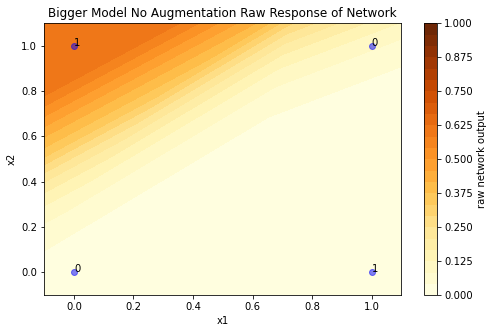

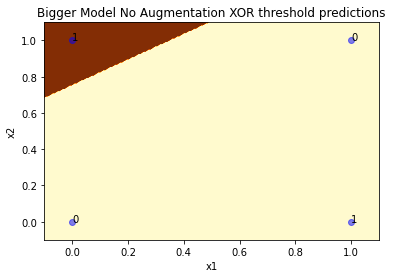

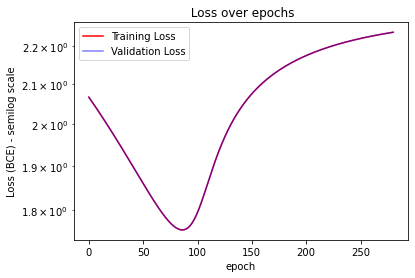

In [16]:
X, Y = get_input_output_data(gate='XOR')

trainX = X
trainY = Y
valX = X
valY = Y

#note that the underscore below says dont capture the returned training history from the model trainer (otherwise it would print out to screen)
_ =train_ANN_model(bigger_model,trainX,trainY,valX,valY,
                learning_rate=LEARNING_RATE,lr_decay=LEARNING_RATE_DECAY,
                valPatience = VAL_PATIENCE, maxEpochs = MAX_EPOCHS, plotname = "Bigger Model No Augmentation")

Results:  Notice that this larger capacity model is not yet able to model XOR and overfits quickly

Can you explain why?


---

## Train the bigger capacity model with the augmented Data 



 BEFORE TRAINING (randomized weights)


input width:  2
Layer  0
[ 1.62434536 -0.61175641]    [0.3190391]
[-0.52817175 -1.07296862]    [-0.24937038]
[ 0.86540763 -2.3015387 ]    [1.46210794]
[ 1.74481176 -0.7612069 ]    [-2.06014071]
Layer  1
[ 1.62434536 -0.61175641 -0.52817175 -1.07296862]    [-0.17242821]
[ 0.86540763 -2.3015387   1.74481176 -0.7612069 ]    [-0.87785842]
[ 0.3190391  -0.24937038  1.46210794 -2.06014071]    [0.04221375]
[-0.3224172  -0.38405435  1.13376944 -1.09989127]    [0.58281521]
Layer  2
[ 1.62434536 -0.61175641 -0.52817175 -1.07296862]    [0.86540763]
output width:  1


predictions: 
 [[False]
 [ True]
 [False]
 [ True]]
Predictions correct?: 
 [[ True]
 [ True]
 [False]
 [False]]
Training Model...

 
 >>> Early Stopping ( 201 ) at training epoch:  1120
       Restoring best model from epoch:  919
Training Complete!

 
 AFTER TRAINING (learned model weights) 


input width:  2
Layer  0
[ 2.13864151 -2.0438947 ]    [0.29157018]
[-0.72848057 -2.20270091]    [-0

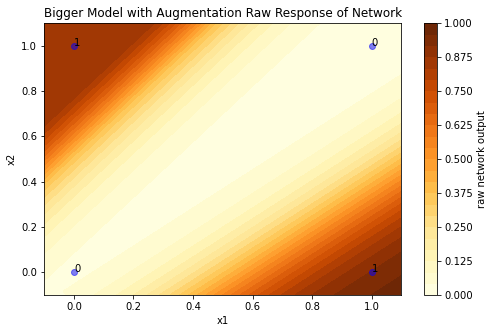

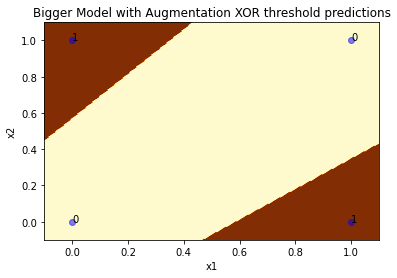

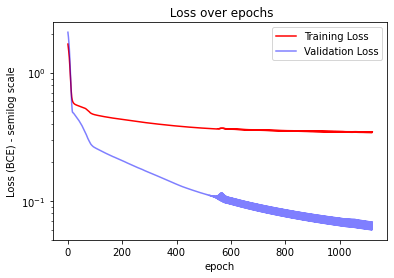

In [17]:
trainX = x_augmented  #use the augmented training data
trainY = y_augmented

valX,valY=X,Y

bigger_model.initialize(seed = NETWORK_INIT_SEED)  #reset the model initial weights

#note that the underscore below means "dont capture the returned training history from the model trainer" (otherwise it would print out to screen)

_ = train_ANN_model(bigger_model,trainX,trainY,valX,valY,
                learning_rate=LEARNING_RATE,lr_decay=LEARNING_RATE_DECAY,
                valPatience = VAL_PATIENCE, maxEpochs = MAX_EPOCHS, plotname = "Bigger Model with Augmentation")

Notice that the bigger capacity model with early stopping and data augmentation works well and produced a decision boundary for XOR... perhaps not the best... but it works